The proposed intrusion detection system in [1] detects whether a packet contains a potential attack. We have created a response that can be implemented to such systems.. If a packet is deemed safe, it will go through a hash-based message authentication code process where it will receive a key for further processing.

In [4]:
import pandas as pd  # type: ignore
import hmac
import hashlib

# Path to the CSV file
file_path = 'CICIDS2017_sample.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)


In [5]:
benign_count = 0
attack_count = 0

for status in df['Label']:
    if status == 'BENIGN':
        benign_count += 1
    else:  
        attack_count += 1

Safe: 22731 
Attack detected: 33930


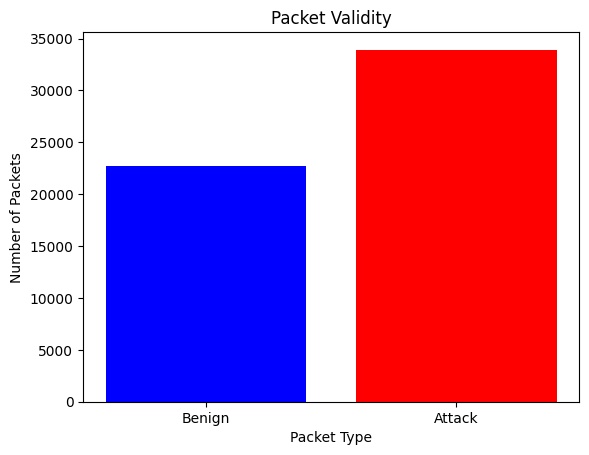

In [6]:
import matplotlib.pyplot as plt  # type: ignore

print(f'Safe: {benign_count} ')
print(f'Attack detected: {attack_count}')

packet_counts = {'Benign': benign_count, 'Attack': attack_count}

plt.bar(packet_counts.keys(), packet_counts.values(), color=['blue', 'red'])
plt.title("Packet Validity")
plt.xlabel("Packet Type")
plt.ylabel("Number of Packets")
plt.show()

The following columns in each row are encrypted into a key: Active Min, Idle Mean, Idle Std, Idle Max, Idle Min, and Label. This results in a secure hash-based message authentication code for every valid packet.

In [7]:
def applyhmac(row):
    #Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
    # data = f"{row['Active Min']}, {row['Idle Mean']}, {row['Idle Std']}, {row['Idle Max']}, {row['Idle Min']}, {row['Label']}".encode()
    data = ', '.join(map(str, row.values)).encode()
    secret_key= b'thisisthekey'
    hmac_result = hmac.new(secret_key, data, hashlib.sha256)

    return hmac_result.hexdigest()

If a packet is benign, the HMAC function will be applied.

In [8]:
df['HMAC'] = df.apply(lambda row: applyhmac(row) if row['Label'] == 'BENIGN' else "notvalid", axis=1)

In [9]:
df.to_csv('benign_with_hmac.csv', index=False)

In [10]:
df = pd.read_csv('benign_with_hmac.csv')
(df['HMAC'])

0        9bb18b548b6971c329a013ad8d2c9c76769e126c7e3b8c...
1        0b0c4a42e5f4a0f56b58b48ff796e05c377d697ccdddf6...
2        4954bbe87c8c7dfab285cb9b5f0cd18ed79eb4cc1c27b6...
3        b98cd48fbeb6f8cd734d425eba9dc848c884b17d7e9a47...
4        5c7b2d34fe1f12eb4818e35413c6b73e0b23898d96f41e...
                               ...                        
56656    ed85044a6ee7e9db52903373f9c7d8075f7a6f2844ba43...
56657    945dd7a3ab757d494d3c7edbbddfddc7b321e95648fe3e...
56658                                             notvalid
56659                                             notvalid
56660                                             notvalid
Name: HMAC, Length: 56661, dtype: object

In [11]:
hashed_count = 0
blocked = 0

for status in df['Label']:
    if status == 'BENIGN':
        hashed_count += 1
    else:  
        blocked += 1

Accepted Packets: 22731 
Blocked Packets: 33930


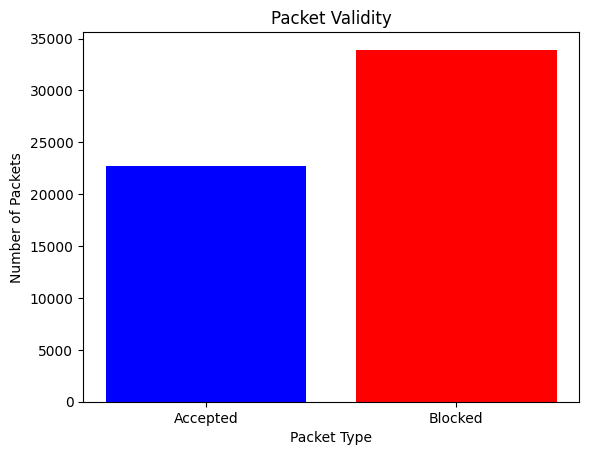

In [12]:
import matplotlib.pyplot as plt  # type: ignore

print(f'Accepted Packets: {hashed_count} ')
print(f'Blocked Packets: {blocked}')

packet_counts = {'Accepted': hashed_count, 'Blocked': blocked}

plt.bar(packet_counts.keys(), packet_counts.values(), color=['blue', 'red'])
plt.title("Packet Validity")
plt.xlabel("Packet Type")
plt.ylabel("Number of Packets")
plt.show()

In [13]:
# HMAC verification function
def verify_hmac(row, secret_key):
    
    data = ', '.join(map(str, row.drop(labels=['HMAC']).values)).encode()  
    # use the shared secret key
    computed_hmac = hmac.new(secret_key, data, hashlib.sha256).hexdigest()
    
    return computed_hmac == row['HMAC']

file_path = 'benign_with_hmac.csv'


In [14]:

# Read the file into a DataFrame
df = pd.read_csv(file_path)

# shared secret key
shared_key = b'thisisthekey'

# Apply the verification function 
df['Valid'] = df.apply(lambda row: verify_hmac(row, shared_key), axis=1)

# Save the verification results
output_file = 'verified_packets.csv'
df.to_csv(output_file, index=False)

# RESULTS 
valid_count = df['Valid'].sum()
invalid_count = len(df) - valid_count


In [15]:

print(f"Valid Packets: {valid_count}")
print(f"Invalid Packets: {invalid_count}")
print(f"Verification results saved to: {output_file}")


Valid Packets: 22731
Invalid Packets: 33930
Verification results saved to: verified_packets.csv


Simulation of packet processing without HMAC

In [16]:
import socket

def send_packet_to_vehicle(packet_data):
    vehicle_ip = "127.0.0.1"  # Localhost for testing
    vehicle_port = 8080  # Port to send the packet to

    # Create a UDP socket to send the packet
    client_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    client_socket.sendto(packet_data.encode(), (vehicle_ip, vehicle_port))
    client_socket.close()

# Example: Sending the "Label" column data over UDP
file_path = 'CICIDS2017_sample.csv'
df = pd.read_csv(file_path)

# Send packets only for Benign and Attack labels
count = 0

for index, row in df.iterrows():
    packet_data = row['Label']  # Only send the "Label" (Benign/Attack)
    send_packet_to_vehicle(packet_data)
    count += 1

print("Number of packets sent: ", count)
    

Number of packets sent:  56661


In [17]:
def simulate_vehicle_server():
    print("Vehicle listening for packets ...")
    vehicle_ip = "127.0.0.1"  # Can be modified to actual vehicle IP)
    vehicle_port = 8080  # Port for listening to packets

    # Create a UDP socket for the vehicle to receive packets
    vehicle_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    vehicle_socket.bind((vehicle_ip, vehicle_port))


    flag = True

    while True:
            
            packet, addr = vehicle_socket.recvfrom(1024)  # Max packet size 1024 bytes
            print(f"Received packet from {addr}: {packet.decode()}")
    
            vehicle_socket.close()

simulate_vehicle_server()


Vehicle listening for packets ...


KeyboardInterrupt: 

In [2]:
import pandas as pd
import hmac
import hashlib
import socket
import json

# HMAC verification function
def verify_hmac(row, secret_key):
    data = ', '.join(map(str, row.drop(labels=['HMAC']).values)).encode()
    computed_hmac = hmac.new(secret_key, data, hashlib.sha256).hexdigest()
    return computed_hmac == row['HMAC']

# UDP packet sender function
def send_udp_packets(df, destination_ip, destination_port):
    # Create a UDP socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    
    # Counters for tracking sent packets
    valid_sent = 0
    invalid_blocked = 0

    for index, row in df.iterrows():
        packet = {
            "data": ', '.join(map(str, row.drop(labels=['Valid', 'HMAC']).values)),
            "HMAC": row['HMAC'],
            "Valid": row['Valid']
        }

        # Serialize packet to JSON
        packet_json = json.dumps(packet).encode()

        if row['Valid']:
            # Send packet
            sock.sendto(packet_json, (destination_ip, destination_port))

        # Update counters
        if row['Valid']:
            valid_sent += 1
        else:
            invalid_blocked += 1

        # Report every 1000 packets
        if valid_sent % 1000 == 0 and row['Valid']:
            print(f"{valid_sent} valid packets sent...")
        if invalid_blocked % 1000 == 0 and not row['Valid']:
            print(f"{invalid_blocked} invalid packets blocked...")   
    # Close socket
    sock.close()
    print("All packets sent.")
    print(f"Total valid packets sent: {valid_sent}")
    print(f"Total invalid packets blocked: {invalid_blocked}")

# Configuration
file_path = '/Users/erikatorres/cs 4371 hmac/benign_with_hmac.csv'
shared_key = b'thisisthekey'
destination_ip = '127.0.0.1'
destination_port = 8080      

# Read and process the CSV file
df = pd.read_csv(file_path)
df['Valid'] = df.apply(lambda row: verify_hmac(row, shared_key), axis=1)


In [3]:

# HMAC verification function
def verify_hmac(packet, secret_key):
    try:
        # Extract data and HMAC from the packet
        data = packet["data"].encode()  # Data is already a string
        hmac_received = packet["HMAC"]

        # Compute HMAC using the shared secret key
        computed_hmac = hmac.new(secret_key, data, hashlib.sha256).hexdigest()

        # Check if the packet is valid (HMAC matches and "Valid" flag is True)
        return packet["Valid"] and computed_hmac == hmac_received
    except Exception as e:
        print(f"Error verifying HMAC: {e}")
        return False

# UDP packet receiver function
def receive_udp_packets(listening_ip, listening_port, secret_key):
    # Create a UDP socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.bind((listening_ip, listening_port))
    print(f"Listening on {listening_ip}:{listening_port}")

    send_udp_packets(df, destination_ip, destination_port)

    # Counter for invalid packets
    invalid_packets = 0

    try:
        while True:
            # Receive packet
            packet_data, addr = sock.recvfrom(1024)  # Buffer size is 1024 bytes
            packet = json.loads(packet_data.decode())

            # Verify packet validity
            if verify_hmac(packet, secret_key):
                print(f"Valid packet received from {addr}: {packet['data']}")
            else:
                print(f"Invalid packet detected from {addr}: {packet['data']}")
                invalid_packets += 1

            # Output the count of invalid packets if any are detected
            if invalid_packets > 0:
                print(f"Invalid packets that have slipped in: {invalid_packets}")

    except KeyboardInterrupt:
        print("Receiver terminated by user.")
    finally:
        if invalid_packets == 0:
            print("No invalid packets were transfered")
        sock.close()

# Configuration
listening_ip = "127.0.0.1"
listening_port = 8080  # Match the sender's port
shared_key = b'thisisthekey'

# Start the receiver
receive_udp_packets(listening_ip, listening_port, shared_key)

Listening on 127.0.0.1:8080
1000 invalid packets blocked...
2000 invalid packets blocked...
3000 invalid packets blocked...
4000 invalid packets blocked...
5000 invalid packets blocked...
6000 invalid packets blocked...
1000 valid packets sent...
7000 invalid packets blocked...
8000 invalid packets blocked...
9000 invalid packets blocked...
10000 invalid packets blocked...
11000 invalid packets blocked...
12000 invalid packets blocked...
13000 invalid packets blocked...
2000 valid packets sent...
14000 invalid packets blocked...
3000 valid packets sent...
15000 invalid packets blocked...
16000 invalid packets blocked...
4000 valid packets sent...
5000 valid packets sent...
6000 valid packets sent...
7000 valid packets sent...
8000 valid packets sent...
9000 valid packets sent...
10000 valid packets sent...
11000 valid packets sent...
12000 valid packets sent...
17000 invalid packets blocked...
18000 invalid packets blocked...
13000 valid packets sent...
14000 valid packets sent...
1900